# Imports and installs

In [ ]:
#pip install XGBoost

In [1]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
import shap

/home/jonathan/.pyenv/versions/3.8.12/envs/OnThePitch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the Dataframe

## Merging the Seasons csv files (2019-2020 untill 2021-2022)

In [2]:
# Customise based on your path and folder organisation
print(os.listdir('../raw_data/All4'))

['spain_2019_2020_1.csv', 'italy_2020_2021_2.csv', 'germany2_2019_2020.csv:Zone.Identifier', 'england3_2019_2020.csv:Zone.Identifier', 'england4_2020_2021.csv:Zone.Identifier', 'italy_2021_2022_1.csv', 'italy_2020_2021.csv:Zone.Identifier', 'italy_2021_2022_2.csv', 'spain_2020_2021_1.csv', 'scotland4_2021_2022.csv:Zone.Identifier', 'portugal_2020_2021.csv:Zone.Identifier', 'scotland_2021_2022.csv:Zone.Identifier', 'germany2_2020_2021.csv:Zone.Identifier', 'spain_2020_2021_2.csv', 'scotland_2020_2021_2.csv', 'Turkey_2021_2022_1.csv', 'france2_2021_2022.csv:Zone.Identifier', 'scotland_2020_2021_3.csv', 'scotland2_2020_2021.csv:Zone.Identifier', 'scotland_2019_2020_1.csv', 'england3_2021_2022.csv:Zone.Identifier', 'france_2019_2020.csv:Zone.Identifier', 'france_2021_2022_1.csv', 'england2_2020_2021.csv:Zone.Identifier', 'germany_2021_2022_1.csv', 'belgium_2020_2021_1.csv', 'scotland_2021_2022_4.csv', 'Eredivisie_2020_2021.csv:Zone.Identifier', 'Greece_2020_2021.csv:Zone.Identifier', 'scot

In [3]:
# Concatenate all the CSVs

files = [file for file in os.listdir('../raw_data/All4') if file.endswith('.csv')]
data = pd.DataFrame()

for file in files:
    df = pd.read_csv('../raw_data/All4/' + file)
    df['country']=str(file)[0:2]
    df['country_division']=int(str(file)[-5:-4])
    data = pd.concat([data, df])

In [4]:
def get_data(league1, wall=False):
    if wall:
        data = pd.DataFrame()
        leagues = listdir(f'./../raw_data/')
        data = pd.DataFrame()
        for league in leagues:
            files = listdir(f'./../raw_data/{league}')
            for file in files:
                df = pd.read_csv((f'./../raw_data/{league}/'+file))
                df['country']=str(file)[0:2]
                data = pd.concat([data, df])
        return data
    else:
        files = [file for file in listdir(f'./../raw_data/{league1}')]
        data = pd.DataFrame()
        for file in files:
            df = pd.read_csv(f'./../raw_data/{league1}/'+file)
            data = pd.concat([data, df])
        return data

# Features Engineering

In [5]:
#Loading the function

def feature_engineering(data, b=20, binned=False):
    '''
    This function creates all the columns that will be needed to create the analysis 
    and return the dataframe with all this changes
    
    b is the number of bins that we want to work with. Our start value for b will be 20.
        '''
    #------------------------Number of Goals, Over and Under -----------------------------------
    
    # total number of goals = goals from the home team + goals from visiting team
    data['nb_goals']=data['FTHG']+data['FTAG']

    # boolean: true or false regarding whether they were more than 2.5 goals
    data['over_2.5_goals']=data['nb_goals']>2.5

    # boolean: true or false regarding whether they were less than 2.5 goals
    data['under_2.5_goals']=data['nb_goals']<2.5
    
    #-----------------------------Payout Opening ----------------------------------------------
    
    # payout under 2.5 for Average OPENING odds
    data['payout_avg_under_2.5'] = data['under_2.5_goals']*data['Avg<2.5']

    # payout over 2.5 for Average OPENING odds
    data['payout_avg_over_2.5'] = data['over_2.5_goals']*data['Avg>2.5']

    #payout UNDER 2.5 for PINACLE specifically
    data['payout_under_2.5_pinacle'] = data['under_2.5_goals']*data['P<2.5']

    #payout OVER 2.5 for PINACLE specifically
    data['payout_over_2.5_pinacle'] = data['over_2.5_goals']*data['P>2.5']

    #payout UNDER 2.5 for 365 specifically
    data['payout_under_2.5_365'] = data['under_2.5_goals']*data['B365<2.5']

    #payout OVER 2.5 for 365 specifically
    data['payout_over_2.5_365'] = data['over_2.5_goals']*data['B365>2.5']
    
    #------------------------------Payout Closing --------------------------------------------
    
    # payout under 2.5 for Average CLOSING odds
    data['payout_avg_under_closing_2.5'] = data['under_2.5_goals']*data['AvgC<2.5']

    # payout over 2.5 for Average CLOSING odds
    data['payout_avg_over_closing_2.5'] = data['over_2.5_goals']*data['AvgC>2.5']

    #payout UNDER 2.5 for PINACLE closing ddds specifically
    data['payout_under_2.5_pinacle_closing'] = data['under_2.5_goals']*data['PC<2.5']

    #payout OVER 2.5 for PINACLE closing odds specifically
    data['payout_over_2.5_pinacle_closing'] = data['over_2.5_goals']*data['PC>2.5']

    #payout UNDER 2.5 for 365 closing odds specifically
    data['payout_under_2.5_365_closing'] = data['under_2.5_goals']*data['B365C<2.5']

    #payout OVER 2.5 for 365 closing odds specifically
    data['payout_over_2.5_365_closing'] = data['over_2.5_goals']*data['B365C>2.5']
    
    #-------------------------- Implied Probability Opening ----------------------------------------
    
    #Implied Probability UNDER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability <2.5 avg']=1/data['Avg<2.5']*100

    #Implied Probability OVER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability >2.5 avg']=1/data['Avg>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE
    data['Implied Probability <2.5 pinacle']=1/data['P<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE
    data['Implied Probability >2.5 pinacle']=1/data['P>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365
    data['Implied Probability <2.5 365']=1/data['B365<2.5']*100

    #Implied Probability OVER 2.5 goals for 365
    data['Implied Probability >2.5 365']=1/data['B365>2.5']*100
    
    #------------------------- Implied Probability Closing -----------------------------------
    
    #Implied Probability UNDER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability <2.5 avg closing']=1/data['AvgC<2.5']*100

    #Implied Probability OVER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability >2.5 avg closing']=1/data['AvgC>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE closing odds
    data['Implied Probability <2.5 pinacle closing']=1/data['PC<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE closing odds
    data['Implied Probability >2.5 pinacle closing']=1/data['PC>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365 closing odds
    data['Implied Probability <2.5 365 closing']=1/data['B365C<2.5']*100

    #Implied Probability OVER 2.5 goals for 365 closing odds
    data['Implied Probability >2.5 365 closing']=1/data['B365C>2.5']*100
    
    #---------------------------- Binning IP Opening -------------------------------------

    b=b
    bins = np.arange(0, 101, int(100/b))
    bins = bins.tolist()

    #Binning UNDER 2.5 Average Market opening odds
    data['binned <2.5 avg'] = pd.cut(data['Implied Probability <2.5 avg'], bins)

    #Binning Over 2.5 Average Market opening odds
    data['binned >2.5 avg'] = pd.cut(data['Implied Probability >2.5 avg'], bins)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned <2.5 pinacle'] = pd.cut(data['Implied Probability <2.5 pinacle'], bins)

    #Binned OVER 2.5 Pinnacle
    data['binned >2.5 pinacle'] = pd.cut(data['Implied Probability >2.5 pinacle'], bins)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned <2.5 365'] = pd.cut(data['Implied Probability <2.5 365'], bins)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned >2.5 365'] = pd.cut(data['Implied Probability >2.5 365'], bins)
    
    #----------------------------- Binning IP Closing ------------------------------------------------

    #Binning UNDER 2.5 Average Market closing odds
    data['binned <2.5 avg closing'] = pd.cut(data['Implied Probability <2.5 avg closing'], bins)

    #Binning OVER 2.5 Average Market closing odds
    data['binned >2.5 avg closing'] = pd.cut(data['Implied Probability >2.5 avg closing'], bins)

    #Binned UNDER 2.5 Pinnacle closing odds
    data['binned <2.5 pinacle closing'] = pd.cut(data['Implied Probability <2.5 pinacle closing'], bins)

    #Binned OVER 2.5 Pinnacle CLOSING odds
    data['binned >2.5 pinacle closing'] = pd.cut(data['Implied Probability >2.5 pinacle closing'], bins)

    #Binned UNDER 2.5 bet365 CLOSING odds
    data['binned <2.5 365 closing'] = pd.cut(data['Implied Probability <2.5 365 closing'], bins)

    #Binned OVER 2.5 bet365 CLOSING odds
    data['binned >2.5 365 closing'] = pd.cut(data['Implied Probability >2.5 365 closing'], bins)
    
    #---------------------------- Binning Odds Opening ----------------------------------------------------
    
    bins2 = [1, 1.5, 2, 3, 10]

    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg'] = pd.cut(data['Avg<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg'] = pd.cut(data['Avg>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle'] = pd.cut(data['P<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle'] = pd.cut(data['P>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365'] = pd.cut(data['B365<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365'] = pd.cut(data['B365>2.5'], bins2)
    
    #----------------------------- Binning Odds Closing ----------------------------------------------------------
    
    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg closing'] = pd.cut(data['AvgC<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg closing'] = pd.cut(data['AvgC>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle closing'] = pd.cut(data['PC<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle closing'] = pd.cut(data['PC>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365 closing'] = pd.cut(data['B365C<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365 closing'] = pd.cut(data['B365C>2.5'], bins2)
    
    
    #----------------------------- Other Features from D3 ------------------------------------------------------
    
    data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
    data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
    data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
    data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
    data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
    data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
    
    #----------------------- Odds and probability of the home team scoring under 2.5 -------------------------------
    
#     lst1 = []
#     lst2 = []
#     for i, team in enumerate(data['HomeTeam']):
#         date = data['Date'].iloc[i]
#         total = len(data[(data['HomeTeam'] == team) & (data['Date'] < date)])
#         n_under_home = data[(data['HomeTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
#         try:
#             lst1.append(1/(n_under_home[1]/total))
#             lst2.append(n_under_home[1]/total)
#         except:
#             lst1.append(np.nan)
#             lst2.append(np.nan)

#     data['odds_home_under'] = lst1
#     data['prob_home_under'] = lst2
    
#     #binning the probability of the home team to have a game of less than 2.5 score
#     data['binned prob_home_under'] = pd.cut(data['prob_home_under']*100, bins)
    
    
    #----------------------- Odds and probability of the away team scoring under 2.5 -------------------------------
    
#     lst3 = []
#     lst4  = []
#     for i, team in enumerate(data['AwayTeam']):
#         date = data['Date'].iloc[i]
#         total2 = len(data[(data['AwayTeam'] == team) & (data['Date'] < date)])
#         n_under_away2 = data[(data['AwayTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
#         try:
#             lst3.append(1/(n_under_away2[1] / total2))
#             lst4.append(n_under_away2[1] / total2)
#         except:
#             lst3.append(np.nan)
#             lst4.append(np.nan)

#     data['odds_away_under'] = lst3
#     data['prob_away_under'] = lst4
    
#     #binning the probability of the away team to have a game of less than 2.5 score
#     data['binned prob_away_under'] = pd.cut(data['prob_away_under']*100, bins)

    #-------------------------- Creating the prob and odds of the game -----------------------------------------------
#     '''the mean between the probability of the home team to have a score of under 2.5 and the probability 
#     of the away team to do the same'''
    
#     data['odds_game'] = (data['odds_away_under'] +  data['odds_home_under']) / 2
#     data['prob_game'] = (data['prob_away_under'] + data['prob_home_under']) / 2
    
    #-------------------------- OneHotEncoding the binned probabilities columns ------------------------------------------
    

#     if b == 5:
#         data = data[~data['binned prob_home_under'].isna()]
#         ohe = OneHotEncoder(sparse=False)
#         ohe.fit(data[['binned prob_home_under']])
#         bins_encoded = ohe.transform(data[['binned prob_home_under']])
#         data["0, 20"], data["20, 40"], data["40, 60"], data["60, 80"], data["80, 100"] = bins_encoded.T
        
#     if b == 10:
#         data = data[~data['binned prob_home_under'].isna()]
#         ohe = OneHotEncoder(sparse=False)
#         ohe.fit(data[['binned prob_home_under']])
#         bins_encoded = ohe.transform(data[['binned prob_home_under']])
#         data["0, 10"], data["10, 20"], data["20, 30"], data["30, 40"], data["40, 50"], data["50, 60"], \
#         data["60, 70"], data["70, 80"], data["80, 90"], data["90, 100"] = bins_encoded.T
        
#     if b == 20:
#         data = data[~data['binned prob_home_under'].isna()]
#         ohe = OneHotEncoder(sparse=False)
#         ohe.fit(data[['binned prob_home_under']])
#         bins_encoded = ohe.transform(data[['binned prob_home_under']])
#         data["0, 5"], data["5, 10"], data["10, 15"], data["15, 20"], data["20, 25"], data["25, 30"], \
#         data["30, 35"], data["35, 40"], data["40, 45"], data["45, 50"], data["50, 55"], data["55, 60"], \
#         data["60, 65"], data["65, 70"], data["70, 75"], data["75, 80"], data["80, 85"], data["85, 90"], \
#         data["90, 95"], data["95, 100"]= bins_encoded.T
    
    #------------------------------------ Cleaning the data ---------------------------------------------------------
    
    #data = data.dropna(subset=['HomeTeam', 'AwayTeam'], how='any')
    data = data[~data['HomeTeam'].isna()]
    data = data[~data['AwayTeam'].isna()]
    data = data[~data['PC>2.5'].isna()]
    data.drop(columns=['Referee','Unnamed: 105'], inplace=True) #, 'Unnamed: 105' 'Referee', 
    #data.dropna()
    
     #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 pinacle closing']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 pinacle closing']])
    data["1.0_to_1.5"], data["1.5_to_2.0"], data["2.0_to_3"], data["3_to_10"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 pinacle closing', inplace=True)
    
    #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 avg closing']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 avg closing']])
    data["avg_1.0_to_1.5"], data["avg_1.5_to_2.0"], data["avg_2.0_to_3"], data["avg_3_to_10"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 avg closing', inplace=True)
    
    
    #-------------------------- OneHotEncoding the binned countries ------------------------------------------

    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country']])
    bins_encoded = ohe.transform(data[['country']])
    data["country_1"], data["country_2"], data["country_3"], data["country_4"], data["country_5"],data["country_6"], data["country_7"], data["country_8"], data["country_9"], data["country_10"], data["country_11"] = bins_encoded.T
    data.drop(columns='country', inplace=True)

    #-------------------------- OneHotEncoding the binned country divisions ------------------------------------------
    
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country_division']])
    bins_encoded = ohe.transform(data[['country_division']])
    data["country_div_1"], data["country_div_2"], data["country_div_3"], data["country_div_4"] = bins_encoded.T
    #data.drop(columns='country_division', inplace=True)
    
    return data

In [6]:
#Running the function and creating the dataset data

data = feature_engineering(data, b=5)

In [7]:
## WE WILL NEED TO ADD ALL THOSE IN THE feature_engineering FUNCTION

## Adding the Year Feature 
data_date = data['Date']
data_time = data['Time']
data_date_2 = pd.to_datetime(data_date, dayfirst = True)
data_time_2 = pd.to_datetime(data_time, dayfirst = True)
data['month'] = pd.DatetimeIndex(data_date_2).month
data['month_after_July'] = data['month']>=7
data['year'] = pd.DatetimeIndex(data_date_2).year
data['year_2021_2022'] = data['year']>=2021
data['year_2022'] = data['year']>=2022
data['year_2020'] = data['year']==2020
data['season_21_22'] = data_date_2>='2021-09-01'
data['season_20_21'] = (data_date_2>='2020-09-01') & (data_date_2<'2021-09-01')
data['season_training2'] = (data_date_2<'2020-09-01')

data['hour'] = pd.DatetimeIndex(data_time_2).hour
data['game_starts_after_4pm']=data['hour']>=16

#Other features
data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
data['%vig_p_bool'] = data['%vig_p']>3.3
data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
data['%vig_avg_bool'] = data['%vig_avg']>5.4
data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
data['MaxC>2.5_AvgC_relative_diff'] = data['MaxC>2.5']/data['AvgC>2.5']
data['Market_consensus'] = data['MaxC>2.5_AvgC_relative_diff']<1.05

In [8]:
data['%vig_avg'].mean()

5.419418771712283

In [9]:
data['month_number']=data['month']
data['month_number_ratio']=data['month']/12

In [10]:
data['year_number'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})
data['year_number_ratio'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})/4
data['year_number_month_ratio'] = data['year_number']+data['month_number_ratio']
data['year_number_month_decimal'] = data['year_number']+data['month_number']/10

In [11]:
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['year_number']])
    bins_encoded = ohe.transform(data[['year_number']])
    data["year_1"], data["year_2"], data["year_3"], data["year_4"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [12]:
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['month_number']])
    bins_encoded = ohe.transform(data[['month_number']])
    data["month_1"], data["month_2"], data["month_3"], data["month_4"], data["month_5"], data["month_6"], data["month_7"], data["month_8"], data["month_9"], data["month_10"], data["month_11"], data["month_12"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [13]:
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['game_starts_after_4pm']])
    bins_encoded = ohe.transform(data[['game_starts_after_4pm']])
    data["game_starts_after_4pm_1"], data["game_starts_after_4pm_2"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [14]:
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['game_starts_after_4pm']])
    bins_encoded = ohe.transform(data[['game_starts_after_4pm']])
    data["game_starts_after_4pm_1"], data["game_starts_after_4pm_2"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [15]:
data['hour_number'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})
data['hour_number_2'] = data['hour'].map({10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:3, 17:3, 18:3, 19:4, 20:4, 21:4})
data['hour_number_2_ratio'] = data['hour'].map({10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:3, 17:3, 18:3, 19:4, 20:4, 21:4})/4
data['hour_number_ratio'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})/12

In [16]:
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['hour_number_2']])
    bins_encoded = ohe.transform(data[['hour_number_2']])
    data["hour_group_1"], data["hour_group_2"], data["hour_group_3"], data["hour_group_4"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [17]:
data['PC<2.5']

data.rename(columns = {'PC<2.5':'PC_under_2.5'}, inplace = True)

(array([1.0991e+04, 8.0990e+03, 1.3720e+03, 3.1800e+02, 6.9000e+01,
        2.7000e+01, 2.0000e+01, 5.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([1.27 , 1.917, 2.564, 3.211, 3.858, 4.505, 5.152, 5.799, 6.446,
        7.093, 7.74 ]),
 <BarContainer object of 10 artists>)

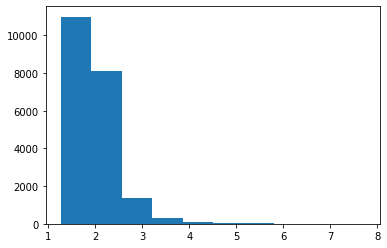

In [18]:
plt.hist(data['PC_under_2.5'])

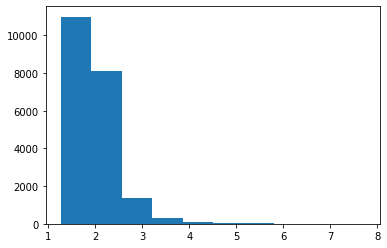

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

plt.hist(data['PC_under_2.5']) # Check if the feature ir normaly distributed

scaler = RobustScaler() # Instanciate MinMaxScalerother scaling method

scaler.fit(data[['PC_under_2.5']]) # Fit scaler to data

data['PC_under_2.5_scaled'] = scaler.transform(data[['PC_under_2.5']]) # Use scaler to transform data

In [20]:
data['PC_under_2.5'].describe()

count    20905.000000
mean         1.983632
std          0.451659
min          1.270000
25%          1.680000
50%          1.890000
75%          2.160000
max          7.740000
Name: PC_under_2.5, dtype: float64

In [21]:
B1 = data['PC_under_2.5'].min()
B2 = np.quantile(data['PC_under_2.5'], 0.25, interpolation='midpoint')
B3 = np.quantile(data['PC_under_2.5'], 0.50, interpolation='midpoint')
B4 = np.quantile(data['PC_under_2.5'], 0.75, interpolation='midpoint')
B5 = data['PC_under_2.5'].max()

the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)


In [22]:
bins = [B1-0.1,B2,B3,B4,B5+0.1]
data["binned_odds"] = pd.cut(data['PC_under_2.5'], bins)

In [23]:
data["binned_odds"].unique()

[(1.89, 2.16], (2.16, 7.84], (1.68, 1.89], (1.17, 1.68]]
Categories (4, interval[float64, right]): [(1.17, 1.68] < (1.68, 1.89] < (1.89, 2.16] < (2.16, 7.84]]

In [24]:
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[["binned_odds"]])
    bins_encoded = ohe.transform(data[["binned_odds"]])
    data["bin_odds_1"], data["bin_odds_2"],data["bin_odds_3"], data["bin_odds_4"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

# Running the XGB model for under 2.5

In [25]:
# Creating the model dataset with relevant variables
data_linear_booleans_lean_P_under = data[['year_number','year_number_ratio','year_number_month_ratio','year_number_month_decimal','month_number','month_number_ratio','country_div_1','country_div_2','country_div_3','country_div_4','month_after_July','season_21_22','year_2020','game_starts_after_4pm','Market_consensus','%vig_p_bool','%vig_avg_bool','avg_1.0_to_1.5','avg_1.5_to_2.0','avg_2.0_to_3','avg_3_to_10','payout_under_2.5_pinacle_closing','year_1','year_2','year_3','year_4','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_number','hour_number_ratio','hour_number_2','hour_number_2_ratio',"game_starts_after_4pm_1","game_starts_after_4pm_2",'hour_group_1','hour_group_2','hour_group_3','hour_group_4','PC_under_2.5_scaled','bin_odds_1','bin_odds_2','bin_odds_3','bin_odds_4','country_division','season_training2','season_20_21','payout_avg_under_closing_2.5']]

## Defining the function testing_models

In [ ]:
X_train = X1[X1['season_21_22']==False]
X_test = X1[X1['season_21_22']==True]
y_train =
y_test = 

In [ ]:
# back up

# results_lr_true = []
# results_lr_false = []

def testing_models(iterations):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_test_0, y_test_0, test_size=test_size_0) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Run Linear Regression
#         results_linear_regression = sm.OLS(y_train,X_train.astype(float)).fit()
#         y_pred_lr = results_linear_regression.predict(X_test.astype(float))
#         #results.summary()

        #Initiate XGBoost
        m = 0
        m = xgb.XGBRegressor()
        
        #Rename columns for XGBoost to run
        ##X_test.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        ##X_train.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        
        #Fit XGBoost
        m.fit(X_train_0,y_train_0) 
        
        #Make and store the predictions XGBoost
        y_pred_xgb = m.predict(X_test)
        y_pred_xgb = pd.DataFrame(y_pred_xgb)

            #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        #Linear Regression
#         y_pred_lr_under_0_median = y_pred_lr[y_pred_lr<0].median()
#         y_pred_lr_under_0_min = y_pred_lr[y_pred_lr<0].min()
#         y_pred_lr_over_0_median = ifnull(y_pred_lr[y_pred_lr>0].median(),0.05)

        #XGB bins
        y_pred_xgb_under_0_median = y_pred_xgb[y_pred_xgb<0].median()
        y_pred_xgb_under_0_min = y_pred_xgb[y_pred_xgb<0].min()
        y_pred_xgb_over_0_median = ifnull(y_pred_xgb[0][y_pred_xgb[0]>0].median(),0.05)

            #------------------------Betting decisions for both models -----------------------------------
#         #Linear Regression
#         bins3_lr = [y_pred_lr_under_0_min-0.0000002, y_pred_lr_under_0_median-0.0000001, 0, y_pred_lr_over_0_median+0.0000001, 1]
#         y_lr_df = pd.DataFrame(y_test)
#         y_pred_lr_df = pd.DataFrame(y_pred_lr)
#         y_pred_lr_df["binned_pred"] = pd.cut(y_pred_lr_df[0], bins3_lr)
#         ind = np.arange(0, len(y_pred_lr_df))
#         ind = ind.tolist()
#         y_lr_df['ind'] = ind
#         y_pred_lr_df['ind'] = ind
#         y_final_lr = y_lr_df.merge(y_pred_lr_df, on="ind")#, on = "axis")#, how = "inner")
#         y_final_lr['bet_opp']=y_final_lr[0]>0

        #XGB
        bins3_xgb = [y_pred_xgb_under_0_min[0]-0.0000002, y_pred_xgb_under_0_median[0]-0.0000001, 0, y_pred_xgb_over_0_median+0.0000001, 1] #int(y_pred_xgb_over_0_median[0])
        y_xgb_df = pd.DataFrame(y_test)
        y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
        y_pred_xgb_df["binned_pred"] = pd.cut(y_pred_xgb_df[0], bins3_xgb)
        y_pred_xgb_df["binned_pred_bin_1"] = y_pred_xgb_df[0]<y_pred_xgb_under_0_median[0]-0.0000001
        y_pred_xgb_df["binned_pred_bin_2"] = (y_pred_xgb_df[0]>y_pred_xgb_under_0_median[0]-0.0000001) & (y_pred_xgb_df[0]<0)
        y_pred_xgb_df["binned_pred_bin_3"] = (y_pred_xgb_df[0]>0) & (y_pred_xgb_df[0]<y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["binned_pred_bin_4"] = (y_pred_xgb_df[0]>y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["bin_number"] = y_pred_xgb_df["binned_pred_bin_1"]*1 + y_pred_xgb_df["binned_pred_bin_2"]*2 + y_pred_xgb_df["binned_pred_bin_3"]*3 + y_pred_xgb_df["binned_pred_bin_4"]*4     
        ind = np.arange(0, len(y_pred_xgb_df))
        ind = ind.tolist()
        y_xgb_df['ind'] = ind
        y_pred_xgb_df['ind'] = ind
        y_final_xgb = y_xgb_df.merge(y_pred_xgb_df, on="ind")#, on = "axis")#, how = "inner")
        
        #Defining the variable bet_opp based on the y_pred of the XGB
        y_final_xgb['bet_opp']=y_final_xgb[0]>0

            #------------------------Getting the results based on predictions -----------------------------------
        #Linear Regression
#         y_final_lr.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
#         y_final_lr.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])

#         y_final_lr.groupby('binned_pred')['payout_under_2.5_pinacle_closing'].count()
#         y_final_lr.groupby('binned_pred')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
#         lr_results_False = y_final_lr[y_final_lr['bet_opp']==False]['payout_under_2.5_pinacle_closing'].mean()
#         lr_results_True = y_final_lr[y_final_lr['bet_opp']==True]['payout_under_2.5_pinacle_closing'].mean()        
        

        #XGB
        #xgb_count = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
        #xgb_mean = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].mean()
        #xgb_results = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
        xgb_results_False = y_final_xgb[y_final_xgb['bet_opp']==False]['payout_avg_under_closing_2.5'].mean()
        xgb_results_True = y_final_xgb[y_final_xgb['bet_opp']==True]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_1 = y_final_xgb[y_final_xgb['bin_number']==1]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_2 = y_final_xgb[y_final_xgb['bin_number']==2]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_3 = y_final_xgb[y_final_xgb['bin_number']==3]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_4 = y_final_xgb[y_final_xgb['bin_number']==4]['payout_avg_under_closing_2.5'].mean()
        
        results_xgb_false.append(xgb_results_False)
        results_xgb_true.append(xgb_results_True)
        results_xgb_1.append(xgb_results_bin_1)
        results_xgb_2.append(xgb_results_bin_2)
        results_xgb_3.append(xgb_results_bin_3)
        results_xgb_4.append(xgb_results_bin_4)
        
        return y_test, y_train_0, y_pred_xgb, y_final_xgb 
        
        i=i+1
        

In [82]:
from sklearn.metrics import r2_score, accuracy_score, precision_score

In [257]:
# results_lr_true = []
# results_lr_false = []

def testing_models_classifier(iterations):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_test_0, y_test_0_classifier, test_size=test_size_0) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Initiate XGBoost
        m = 0
        m = xgb.XGBClassifier()
        
        #Fit XGBoost
        m.fit(X_train_0,y_train_0_classifier) 
        
        #Make and store the predictions XGBoost
        y_pred_test = m.predict(X_test)
        y_pred_test_df = pd.DataFrame(y_pred_test,columns=['prediction'])
        y_pred_train = m.predict(X_train_0)
        y_pred_train_df = pd.DataFrame(y_pred_train)
        y_test_df = pd.DataFrame(y_test).reset_index()
        y_final_df = y_pred_test_df.copy()
        y_final_df['actual'] = y_test_df['payout_avg_under_closing_2.5']

        
        # accuracy
        accuracy_test = accuracy_score(y_test,y_pred_test)
        accuracy_train = accuracy_score(y_train_0_classifier,y_pred_train)
        
        # precision
        precision_test = precision_score(y_test,y_pred_test)
        precision_train = precision_score(y_train_0_classifier,y_pred_train)
    
  #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val
        
        #XGB
        #ind = np.arange(0, len(y_pred_test_df))
        #ind = ind.tolist()
        #y_xgb_df['ind'] = ind
        #y_pred_test_df['ind'] = ind
        
        #Defining the variable bet_opp based on the y_pred of the XGB

        y_final_df['payout_avg_under_closing_2.5'] = y_test_0.loc[y_test.index].reset_index()['payout_avg_under_closing_2.5']
        #import ipdb; ipdb.set_trace()
        #y_final_df['payout_avg_under_closing_2.5'] = 0

        result_False = y_final_df[y_final_df['prediction']==False]['payout_avg_under_closing_2.5'].mean()
        result_True = y_final_df[y_final_df['prediction']==True]['payout_avg_under_closing_2.5'].mean()
        
        results_False.append(result_False)
        results_True.append(result_True)
        
        i=i+1
        
    return accuracy_test, accuracy_train, precision_train, precision_test, y_final_df
        
        
        

In [237]:
accuracy_test, accuracy_train, precision_train, precision_test, y_final_df = testing_models_classifier(10)

In [238]:
y_final_df

,prediction,actual,payout_avg_under_closing_2.5
0,1,False,-1.00
1,0,True,1.80
2,0,True,1.31
3,1,True,0.64
4,1,False,-1.00
...,...,...,...
5932,0,False,-1.00
5933,0,False,-1.00
5934,0,True,1.08
5935,1,True,0.73


In [ ]:
y_final_df

In [62]:
# results_lr_true = []
# results_lr_false = []

def testing_models2(iterations):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_test_0, y_test_0, test_size=test_size_0) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Run Linear Regression
#         results_linear_regression = sm.OLS(y_train,X_train.astype(float)).fit()
#         y_pred_lr = results_linear_regression.predict(X_test.astype(float))
#         #results.summary()

        #Initiate XGBoost
        m = 0
        m = xgb.XGBRegressor()
        
        #Rename columns for XGBoost to run
        ##X_test.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        ##X_train.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        
        #Fit XGBoost
        m.fit(X_train_0,y_train_0) 

        #Make and store the predictions XGBoost
        y_pred_xgb_vector = m.predict(X_test)
        y_pred_xgb = pd.DataFrame(y_pred_xgb_vector)
        y_pred_xgb_train_vector = m.predict(X_train_0)
        y_pred_xgb_train = pd.DataFrame(y_pred_xgb_train_vector)
        r2_score_test = r2_score(y_test,y_pred_xgb_vector)
        r2_score_train = r2_score(y_train_0,y_pred_xgb_train_vector)

            #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        #Linear Regression
#         y_pred_lr_under_0_median = y_pred_lr[y_pred_lr<0].median()
#         y_pred_lr_under_0_min = y_pred_lr[y_pred_lr<0].min()
#         y_pred_lr_over_0_median = ifnull(y_pred_lr[y_pred_lr>0].median(),0.05)

        #XGB bins
        y_pred_xgb_under_0_median = y_pred_xgb[y_pred_xgb<0].median()
        y_pred_xgb_under_0_min = y_pred_xgb[y_pred_xgb<0].min()
        y_pred_xgb_over_0_median = ifnull(y_pred_xgb[0][y_pred_xgb[0]>0].median(),0.05)

            #------------------------Betting decisions for both models -----------------------------------
#         #Linear Regression
#         bins3_lr = [y_pred_lr_under_0_min-0.0000002, y_pred_lr_under_0_median-0.0000001, 0, y_pred_lr_over_0_median+0.0000001, 1]
#         y_lr_df = pd.DataFrame(y_test)
#         y_pred_lr_df = pd.DataFrame(y_pred_lr)
#         y_pred_lr_df["binned_pred"] = pd.cut(y_pred_lr_df[0], bins3_lr)
#         ind = np.arange(0, len(y_pred_lr_df))
#         ind = ind.tolist()
#         y_lr_df['ind'] = ind
#         y_pred_lr_df['ind'] = ind
#         y_final_lr = y_lr_df.merge(y_pred_lr_df, on="ind")#, on = "axis")#, how = "inner")
#         y_final_lr['bet_opp']=y_final_lr[0]>0

        #XGB
        bins3_xgb = [y_pred_xgb_under_0_min[0]-0.0000002, y_pred_xgb_under_0_median[0]-0.0000001, 0, y_pred_xgb_over_0_median+0.0000001, 1] #int(y_pred_xgb_over_0_median[0])
        y_xgb_df = pd.DataFrame(y_test)
        y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
        y_pred_xgb_df["binned_pred"] = pd.cut(y_pred_xgb_df[0], bins3_xgb)
        y_pred_xgb_df["binned_pred_bin_1"] = y_pred_xgb_df[0]<y_pred_xgb_under_0_median[0]-0.0000001
        y_pred_xgb_df["binned_pred_bin_2"] = (y_pred_xgb_df[0]>y_pred_xgb_under_0_median[0]-0.0000001) & (y_pred_xgb_df[0]<0)
        y_pred_xgb_df["binned_pred_bin_3"] = (y_pred_xgb_df[0]>0) & (y_pred_xgb_df[0]<y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["binned_pred_bin_4"] = (y_pred_xgb_df[0]>y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["bin_number"] = y_pred_xgb_df["binned_pred_bin_1"]*1 + y_pred_xgb_df["binned_pred_bin_2"]*2 + y_pred_xgb_df["binned_pred_bin_3"]*3 + y_pred_xgb_df["binned_pred_bin_4"]*4     
        ind = np.arange(0, len(y_pred_xgb_df))
        ind = ind.tolist()
        y_xgb_df['ind'] = ind
        y_pred_xgb_df['ind'] = ind
        y_final_xgb = y_xgb_df.merge(y_pred_xgb_df, on="ind")#, on = "axis")#, how = "inner")
        
        #Defining the variable bet_opp based on the y_pred of the XGB
        y_final_xgb['bet_opp']=y_final_xgb[0]>0

            #------------------------Getting the results based on predictions -----------------------------------
        #Linear Regression
#         y_final_lr.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
#         y_final_lr.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])

#         y_final_lr.groupby('binned_pred')['payout_under_2.5_pinacle_closing'].count()
#         y_final_lr.groupby('binned_pred')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
#         lr_results_False = y_final_lr[y_final_lr['bet_opp']==False]['payout_under_2.5_pinacle_closing'].mean()
#         lr_results_True = y_final_lr[y_final_lr['bet_opp']==True]['payout_under_2.5_pinacle_closing'].mean()        
        

        #XGB
        #xgb_count = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
        #xgb_mean = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].mean()
        #xgb_results = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
        xgb_results_False = y_final_xgb[y_final_xgb['bet_opp']==False]['payout_avg_under_closing_2.5'].mean()
        xgb_results_True = y_final_xgb[y_final_xgb['bet_opp']==True]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_1 = y_final_xgb[y_final_xgb['bin_number']==1]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_2 = y_final_xgb[y_final_xgb['bin_number']==2]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_3 = y_final_xgb[y_final_xgb['bin_number']==3]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_4 = y_final_xgb[y_final_xgb['bin_number']==4]['payout_avg_under_closing_2.5'].mean()
        
        results_xgb_false.append(xgb_results_False)
        results_xgb_true.append(xgb_results_True)
        results_xgb_1.append(xgb_results_bin_1)
        results_xgb_2.append(xgb_results_bin_2)
        results_xgb_3.append(xgb_results_bin_3)
        results_xgb_4.append(xgb_results_bin_4)
        
        return y_test, y_train_0, y_pred_xgb, y_final_xgb, r2_score_test, r2_score_train
        
        i=i+1
        

In [ ]:
import itertools

iterables = [[feature_1], [feature_2], [feature_3]]

for t in itertools.product(*iterables):
    print (t)

In [ ]:
feature_1 = ['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0','3.0_to_99999.0']
feature_2 = ['country_div_1','country_div_2','country_div_3','country_div_4']
feature_3 = ['month_after_July']
feature_4 = ['year_2021_2022']
feature_5 = ['game_starts_after_4pm']
feature_6 = ['Market_consensus']
feature_7 = ['%vig_p_bool']
feature_8 = ['payout_under_2.5_pinacle_closing']

In [ ]:
list_features = [feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8]

In [ ]:
from itertools import combinations
sample_list = list_features
list_combinations = list()
for n in range(len(sample_list) + 1):
    list_combinations += list(combinations(sample_list, n))
print(list_combinations)

In [ ]:
list_combinations

In [ ]:
ls = list(list_combinations)
flat_ls = [item for sublist in ls for item in sublist]

In [ ]:
flat_ls

In [ ]:
a = list(list_combinations[3])

In [ ]:
mylist = list(list_combinations[3])
[item[0] for item in mylist]

In [ ]:
list_features_array = np.array(list_features)

In [ ]:
list_features_array

In [ ]:
np.multiply(x[0]*list_features_array)

In [ ]:
from itertools import product
import numpy as np

n = 2

x = product([1, 0], repeat=n)
x = np.reshape(list(x), (-1, n))
print(x)

In [ ]:
i=1
#while i < 3:
feature_selection_1 = x[0]*list_features_array[i]
i=i=1
final_feature_selection = feature_selection_1+feature_selection_2

In [ ]:
list_features_array[i]

In [ ]:
random_feature_selection = feature_1*0+feature_2

In [ ]:
random_feature_selection

## Running the function testing_models 

In [271]:
data[data['season_training2']==True]['Date'].min()

'01/01/2020'

In [263]:
data[data['season_training2']==True]

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,hour_group_1,hour_group_2,hour_group_3,hour_group_4,PC_under_2.5_scaled,binned_odds,bin_odds_1,bin_odds_2,bin_odds_3,bin_odds_4
0,SP1,16/08/2019,20:00,Ath Bilbao,Barcelona,1,0,H,0.0,0.0,...,0.0,0.0,0.0,1.0,0.083333,"(1.89, 2.16]",0.0,0.0,1.0,0.0
1,SP1,17/08/2019,16:00,Celta,Real Madrid,1,3,A,0.0,1.0,...,0.0,0.0,1.0,0.0,1.812500,"(2.16, 7.84]",0.0,0.0,0.0,1.0
2,SP1,17/08/2019,18:00,Valencia,Sociedad,1,1,D,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.083333,"(1.68, 1.89]",0.0,1.0,0.0,0.0
3,SP1,17/08/2019,19:00,Mallorca,Eibar,2,1,H,1.0,0.0,...,0.0,0.0,0.0,1.0,-0.312500,"(1.68, 1.89]",0.0,1.0,0.0,0.0
4,SP1,17/08/2019,20:00,Leganes,Osasuna,0,1,A,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.875000,"(1.17, 1.68]",1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,SC2,07/03/2020,15:00,Clyde,Dumbarton,2,0,H,0.0,0.0,...,0.0,1.0,0.0,0.0,0.645833,"(2.16, 7.84]",0.0,0.0,0.0,1.0
135,SC2,07/03/2020,15:00,Falkirk,Peterhead,3,0,H,2.0,0.0,...,0.0,1.0,0.0,0.0,0.312500,"(1.89, 2.16]",0.0,0.0,1.0,0.0
136,SC2,07/03/2020,15:00,Montrose,Stranraer,4,1,H,1.0,0.0,...,0.0,1.0,0.0,0.0,0.875000,"(2.16, 7.84]",0.0,0.0,0.0,1.0
137,SC2,07/03/2020,15:00,Raith Rvs,Forfar,2,1,H,1.0,0.0,...,0.0,1.0,0.0,0.0,1.083333,"(2.16, 7.84]",0.0,0.0,0.0,1.0


In [223]:
#reset the indices
data_linear_booleans_lean_P_under.reset_index(inplace=True, drop=True)

# Select here the variables you want to include in the testing
#'hour_number','hour_number_ratio',"hour_10","hour_11","hour_12","hour_13","hour_14","hour_15","hour_16","hour_17","hour_18","hour_19","hour_20","hour_21",'hour_number','hour_number_ratio','hour_number_2_ratio'
X_train_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_avg_bool','Market_consensus','year_number',"game_starts_after_4pm_2","game_starts_after_4pm_1",'avg_1.0_to_1.5','avg_1.5_to_2.0','avg_2.0_to_3','avg_3_to_10']]#,'year_number_ratio','month_number_ratio']]
X_test_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_avg_bool','Market_consensus','year_number',"game_starts_after_4pm_2","game_starts_after_4pm_1",'avg_1.0_to_1.5','avg_1.5_to_2.0','avg_2.0_to_3','avg_3_to_10']]#,'year_number_ratio','month_number_ratio']]
y_train_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False]['payout_avg_under_closing_2.5']-1
y_test_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True]['payout_avg_under_closing_2.5']-1

#creating the classifier model
y_test_0_classifier = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True]['payout_avg_under_closing_2.5']!=0
y_train_0_classifier = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False]['payout_avg_under_closing_2.5']!=0

#div_1',country_div_1','country_div_2','country_div_3','country_div_4

In [225]:
y_test_0

779     -1.00
780     -1.00
781     -1.00
782     -1.00
783     -1.00
         ... 
20594    1.04
20595   -1.00
20596   -1.00
20597   -1.00
20598   -1.00
Name: payout_avg_under_closing_2.5, Length: 6596, dtype: float64

In [124]:
data_linear_booleans_lean_P_under['country_division'].unique()

array([1, 2, 3, 4])

In [75]:
y_train_0_classifier = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False]['payout_avg_under_closing_2.5']==0


In [258]:
# Run the function testing_models
results_xgb_true = [] 
results_xgb_false = []
results_xgb_1=[]
results_xgb_2=[]
results_xgb_3=[]
results_xgb_4=[]
results_False=[]
results_True=[]

In [274]:
test_size_0=0.90
testing_models_classifier(100)
accuracy_test, accuracy_train, precision_train, precision_test, y_final_df = testing_models_classifier(10)

In [275]:
def checking_model_results(n=10):
    
    #empty_lists
    results_False=[]
    results_True=[]
    
    #empty_lists
    accuracy_test, accuracy_train, precision_train, precision_test, y_final_df = testing_models_classifier(n)
    median_results_bad_bets = np.median(np.array(results_False))
    median_results_good_bets = np.median(np.array(results_True))
    
    #Plotting the results of the XGB
    sns.histplot(results_True,kde=True,bins=20,color='green')
    sns.histplot(results_False,kde=True,bins=20,color='red')
    
    return median_results_bad_bets, median_results_good_bets, accuracy_test, accuracy_train, precision_train, precision_test, y_final_df

In [ ]:
checking_model_results(n=10)

In [188]:
y_final_df['actual'].isnull().sum()

5937

In [282]:
y_final_df

,prediction,actual,payout_avg_under_closing_2.5
0,0,False,-1.00
1,1,True,0.66
2,1,False,-1.00
3,1,True,0.70
4,0,False,-1.00
...,...,...,...
5932,0,True,0.59
5933,1,False,-1.00
5934,1,False,-1.00
5935,0,True,0.83


In [101]:
y_final_xgb['decision_criteria']=y_test

reindexing with a non-unique Index is deprecated and will raise in a future version.


ValueError: cannot reindex on an axis with duplicate labels

In [253]:
# Results of the X tests with XGB (that you ran with the function testing_models)
median_results_bad_bets = np.median(np.array(results_xgb_false))
median_results_good_bets = np.median(np.array(results_xgb_true))

Mean of empty slice.
invalid value encountered in double_scalars


In [283]:
results_True

[-0.05427270427523401,
 -0.047463216641298836,
 -0.04843734145104008,
 -0.05259221572119054,
 -0.043384576612903236,
 -0.05077079623505469,
 -0.052211170619739865,
 -0.05759146341463415,
 -0.05894736842105264,
 -0.052222788682131024,
 -0.05813847324372306,
 -0.055176083101089436,
 -0.04875349073368876,
 -0.04432199085830371,
 -0.04984414920797139,
 -0.06105048444671086,
 -0.0587991876110688,
 -0.051987906273620564,
 -0.04831768586653133,
 -0.04685185185185185,
 -0.04848660939868621,
 -0.059313675648195216,
 -0.054855476673428,
 -0.054480749746707205,
 -0.052141772151898726,
 -0.05266413181242079,
 -0.048103579588728115,
 -0.05234861920445908,
 -0.04635835228708617,
 -0.049126559714795015,
 -0.0643474962063733,
 -0.04482706002034589,
 -0.05030326004548901,
 -0.048921245885034194,
 -0.05121204453441295,
 -0.0601645153125791,
 -0.04733417721518987,
 -0.06283684344075108,
 -0.04394663278271919,
 -0.04766092245311708,
 -0.0490782122905028,
 -0.06132996207332492,
 -0.04990106544901066,
 -0.0

In [284]:
results_False

[-0.06192036290322581,
 -0.06637092731829575,
 -0.06786466165413535,
 -0.06507477567298106,
 -0.047673946165566285,
 -0.05351445663010968,
 -0.06794642857142857,
 -0.06582708645677161,
 -0.08937624750499003,
 -0.07129592850049654,
 -0.07852557673019057,
 -0.07025628140703517,
 -0.06766266266266266,
 -0.06317158579289646,
 -0.05758279782501236,
 -0.06579652605459058,
 -0.06815815815815816,
 -0.0701219512195122,
 -0.060045090180360736,
 -0.05861152882205514,
 -0.07507832238504296,
 -0.060539191213180236,
 -0.0728198695434019,
 -0.08713423831070892,
 -0.06669350780070459,
 -0.059482931726907634,
 -0.0694944944944945,
 -0.057763819095477405,
 -0.0685,
 -0.06532835820895523,
 -0.062410489157841656,
 -0.07595012468827932,
 -0.054681818181818186,
 -0.06077967806841047,
 -0.06410579345088163,
 -0.06135448136958712,
 -0.07706592853548062,
 -0.06594188376753507,
 -0.057922077922077916,
 -0.07405826217980915,
 -0.07270135067533767,
 -0.07608980827447023,
 -0.056446115288220564,
 -0.06803634528016

In [285]:
# Results of the X tests with XGB (that you ran with the function testing_models)
median_results_bad_bets = np.median(np.array(results_False))
median_results_good_bets = np.median(np.array(results_True))

In [286]:
median_results_bad_bets

-0.06663449452851844

In [287]:
# Delta variable (gap between bad and good group) is the variable we aim to maximise with our features and models fine-tuning, the greater the better!
delta = np.median(np.array(median_results_good_bets))-np.median(np.array(median_results_bad_bets))

In [288]:
delta_extremes = np.median(np.array(results_xgb_4))-np.median(np.array(results_xgb_1))

Mean of empty slice.
invalid value encountered in double_scalars


In [289]:
best_results = np.median(np.array(results_xgb_4))

In [290]:
worse_results = np.median(np.array(results_xgb_1))

In [291]:
print(delta, delta_extremes)

0.015299620540433469 nan


In [292]:
results_xgb_false

[]

<AxesSubplot:ylabel='Count'>

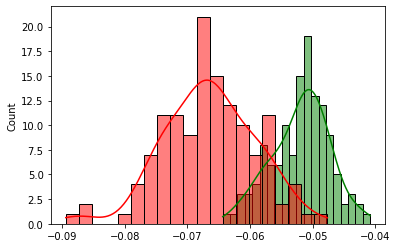

In [293]:
# Plotting the results of the XGB
sns.histplot(results_True,kde=True,bins=20,color='green')
sns.histplot(results_False,kde=True,bins=20,color='red')

<AxesSubplot:>

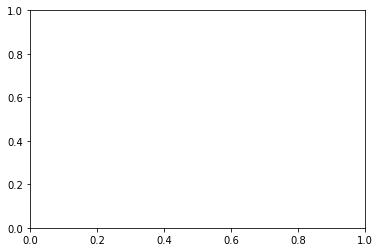

In [271]:
# Plotting the results of the XGB
sns.histplot(results_xgb_true,kde=True,bins=20,color='green')
sns.histplot(results_xgb_false,kde=True,bins=20,color='red')

<AxesSubplot:>

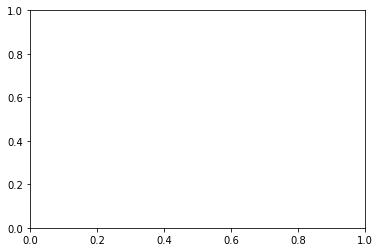

In [272]:
# Plotting the results of the XGB
sns.histplot(results_xgb_1,kde=True,bins=20,color='red')
sns.histplot(results_xgb_2,kde=True,bins=20,color='orange')
sns.histplot(results_xgb_3,kde=True,bins=20,color='grey')
sns.histplot(results_xgb_4,kde=True,bins=20,color='green')

# Comments regarding results of the tests we ran and Next Steps

In [ ]:
## Comments

# baseline = 0.008297694850435258 (all features)

# delta without Joao features = 0.014419296789770412 => F:-0.029970666611150436 and T:-0.015551369821380024
# --> WE REMOVE JOAO FEATURE

# delta when removing the odds buckets = -0.009317543146000251 => F:-0.022611272813043187 and T:-0.028804787343669917
# --> WE KEEP THE ODDS BUCKETS

# delta when removing the odds buckets = -0.009317543146000251 => F:-0.022611272813043187 and T:-0.028804787343669917
# --> WE KEEP THE ODDS BUCKETS

# delta when removing the countries and divisions = 0.004795286566703704
# --> WE KEEP THE COUNTRIES AND DIVISIONS

# delta when removing the divisions but keeping the countries = 0.008380480363148559 (worsening)
# delta when removing the countries but keeping the divisions = 0.02259680830123266 (best score ever)
# --> WE KEEP THE DIVSIONS AND REMOVE THE COUNTRIES

# delta when removing the 'month_after_July': 0.013657154854343441 DECREASED A LOT! We keep month after July
# year 2020_2021 = 0.012829398919170131 DECREASED A LOT! 
# TIME MATTERS!! We need months, years, time

# New basline: 0.023917075840908224

#'Pin pays better' does not improve the baseline and we remove it

#'Market_consensus' MATTERS we keep it

#VIG matters

# We should remove the P<PC variable
# BEST DELTA: 0.03151890594630853


In [ ]:
# Next steps:

## Time: Further explore how to optimise the features of time (years, months, hours, etc.)
## Odds: Further explore how to optimise the odds buckets (different bins, min-max scaling)
## VIG + Mkt Consensus: Further explore how to optimise VIG + Market consensus

In [439]:
m.feature_importances

NameError: name 'm' is not defined

# [SKIP] Other models + stats package we could use [SKIP]

In [ ]:
# Random Forest

In [194]:
my_model = xgb.XGBRegressor()
my_model.fit(X_train_0,y_train_0) 
        
        #Make and store the predictions XGBoost
       # y_pred_xgb = m.predict(X_test)
       # y_pred_xgb = pd.DataFrame(y_pred_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [786]:
#my_model = RandomForestRegressor(random_state=0).fit(X_step_joao, y)

In [195]:
y_pred = my_model.predict(X_test_0)

In [788]:
# SHAP values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


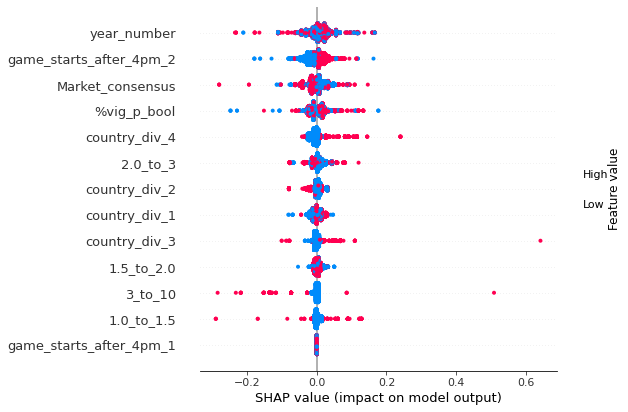

In [196]:
#import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_0)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test_0)

#- Vertical location shows what feature it is depicting
#- Color shows whether that feature was high or low for that row of the dataset
#- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

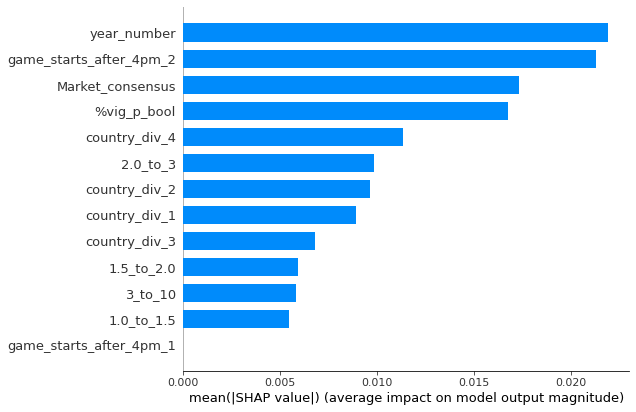

In [197]:
shap.summary_plot(shap_values, X_test_0, plot_type="bar")